# Build a biGRU neural network model with additional features

In this notebook, we are going to build a bidirectional Gated Recurrent Unit neural network model, which will use the clean_review feature as in the previous notebook, but this time we will also use additional features that we created in the first tutorial. The extra features that will be passed to the model are the following: polarity, subjectivity, word count, Part-Of-Speech tags ratio, uppercase words ratio and digits ratio.

In the end, the model will be evaluated on the test set to determine the generalization error.


### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

Now, we are going to load the tarining and validation sets. We will import sets with all columns except the review column.

In [2]:
# Import the dataset. 
train_dataset = pd.read_csv('dataset/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 5
train_dataset = train_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                               'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [3]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
2,young suffering severe extreme neck pain resul...,-0.04166,0.4026,120.0,0.08330,0.00000,0.02500,0.2333,0.2417,0.1333,0.08330,True
5,found work helping good nights sleep don&#039;...,0.70000,0.6000,22.0,0.09090,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,True
9,given medication gastroenterologist office wor...,0.00000,0.0000,36.0,0.08330,0.02777,0.02777,0.2778,0.1389,0.1945,0.05554,False
12,recently laparoscopic hysterectomy know anesth...,-0.29400,0.6970,98.0,0.05103,0.01020,0.00000,0.0000,0.0000,0.0000,0.00000,True
13,mirena year experienced effects effects watch ...,0.80000,0.9000,37.0,0.02702,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,False


Before we create batches of our data, we have to normalize the numerical features so that we remove the possibility that one variable is the orders of magnitude greater than other variables, which might cause that the first one dominates other features in the dataset and this is something we don't want to happen in our model.

The polarity is within the range [-1.0, 1.0], and the subjectivity is within the range [0.0, 1.0], thus these both features don't require the scaling.

In [4]:
# Instantiate the StandardScaler
train_scaler = StandardScaler()
# Scale the features
train_dataset.iloc[:, 3:11] = train_scaler.fit_transform(train_dataset.iloc[:, 3:11])

In [5]:
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
2,young suffering severe extreme neck pain resul...,-0.04166,0.4026,0.795535,0.658979,-0.797571,0.737436,2.136339,2.163294,0.986274,1.449606,True
5,found work helping good nights sleep don&#039;...,0.70000,0.6000,-1.400104,0.858111,-0.797571,-0.363838,-0.549302,-0.532286,-0.435852,-0.455429,True
9,given medication gastroenterologist office wor...,0.00000,0.0000,-1.086442,0.658979,0.619398,0.859457,2.648602,1.016808,1.639193,0.814747,False
12,recently laparoscopic hysterectomy know anesth...,-0.29400,0.6970,0.302636,-0.186546,-0.277114,-0.363838,-0.549302,-0.532286,-0.435852,-0.455429,True
13,mirena year experienced effects effects watch ...,0.80000,0.9000,-1.064037,-0.815646,-0.797571,-0.363838,-0.549302,-0.532286,-0.435852,-0.455429,False


In [6]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= 5
val_dataset = val_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                           'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [7]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna(0)
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,year old son took night went deep sea fishing ...,0.0250,0.1813,66.0,0.01515,0.03030,0.01515,0.2122,0.1970,0.0909,0.04544,True
1,daughter epiduo grade junior year work wonders...,0.1320,0.4402,128.0,0.06250,0.01563,0.03125,0.1641,0.2266,0.1719,0.08594,True
2,i&#039;ve implant months day got totally felt ...,0.1597,0.5520,148.0,0.06082,0.02702,0.00000,0.0000,0.0000,0.0000,0.00000,True
3,wanted wait days post couldn&#039;t results am...,0.2349,0.5977,102.0,0.07840,0.05884,0.00000,0.0000,0.0000,0.0000,0.00000,True
4,colonoscopy best prep far morning took prep pm...,0.0782,0.4224,136.0,0.08090,0.05148,0.00000,0.0000,0.0000,0.0000,0.00000,True


In [8]:
# Instantiate the StandardScaler
val_scaler = StandardScaler()
# Scale the features
val_dataset.iloc[:, 3:11] = val_scaler.fit_transform(val_dataset.iloc[:, 3:11])

In [9]:
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,year old son took night went deep sea fishing ...,0.0250,0.1813,-0.427152,-1.088387,0.742878,0.335276,1.960854,1.736428,0.566978,0.668738,True
1,daughter epiduo grade junior year work wonders...,0.1320,0.4402,0.912863,0.116713,-0.019665,1.066186,1.396558,2.073946,1.436693,1.673646,True
2,i&#039;ve implant months day got totally felt ...,0.1597,0.5520,1.345125,0.073955,0.572384,-0.352506,-0.528619,-0.509889,-0.409036,-0.458743,True
3,wanted wait days post couldn&#039;t results am...,0.2349,0.5977,0.350921,0.521382,2.226379,-0.352506,-0.528619,-0.509889,-0.409036,-0.458743,True
4,colonoscopy best prep far morning took prep pm...,0.0782,0.4224,1.085768,0.585010,1.843809,-0.352506,-0.528619,-0.509889,-0.409036,-0.458743,True


Below we will use the BatchIterator class defined in the *vocabulary* notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

We will use the min_word_count=3 and max_seq_len=0.9 as in the previous model. The batch_size entry value will be the 256, but it will turn out during the fine-tuning process (that is not presented) that for the dataset with more features the model achieves superior performance with the smaller size of the batch (batch_size=64) which helps in preventing overfitting.

In [10]:
train_iterator = BatchIterator(train_dataset, batch_size=64, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=False, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
8674/21861 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 58
Mapped words to indices
Batches created


In [11]:
val_iterator = BatchIterator(val_dataset, batch_size=64, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
4655/11853 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 57
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [12]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_feat', 'input_seq', 'target', 'x_lengths'])


As we can see above we can distinguish the following batches: *input_feat* that comprises all additional features, *input_seq* that contains cleaned reviews, *target batch* that includes target labels and *x_lengths* batch that encompasses input sequences lengths.

Notice that the *input_seq* batch has the dimensions: (batch_size, seq_len), while *input_feat* batch has the shape of (batch_size, num_features).

In [13]:
for batches in train_iterator:

    # Unpack the dictionary of batches
    input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                               batches['target'], batches['x_lengths']
        
    print('input_seq shape: ', input_seq.size())
    print('input_feat shape: ', input_feat.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([64, 53])
input_feat shape:  torch.Size([64, 10])
target shape:  torch.Size([64])
x_lengths shape:  torch.Size([64])


In [14]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                               batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('input_feat shape: ', input_feat.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([64, 58])
input_feat shape:  torch.Size([64, 10])
target shape:  torch.Size([64])
x_lengths shape:  torch.Size([64])


Now we are going to build a biGRU model that will use the *input_feat* batch as additional features vector. 

In [15]:
class BiGRU(nn.Module):
    """BiDirectional GRU neural network model.
        
    Parameters
    ----------
    hidden_size: int
        Number of features in the hidden state.
    vocab_size: int
        The size of the vocabulary.
    n_extra_feat: int
        Number of additional features.
    embedding_dim: int
        The size of each embedding vector.
    output_size: int
        Number of classes.
    n_layers: int, optional (default=1)
        Number of stacked recurrent layers.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout.
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU.

    """
    
    def __init__(self, hidden_size, vocab_size, n_extra_feat, embedding_dim, output_size, n_layers=1, dropout=0.2,
                 spatial_dropout=True, bidirectional=True):
        
        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()
        
        # Initialize attributes
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_extra_feat = n_extra_feat
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(self.dropout_p)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, 
                          dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True,
                          bidirectional=self.bidirectional)
        # Linear layer input size is equal to hidden_size * 3 + n_extra_feat, becuase
        # we will concatenate max_pooling ,avg_pooling, last hidden state and additional features
        self.linear = nn.Linear(self.hidden_size * 3 + self.n_extra_feat, self.output_size)

        
    def forward(self, input_seq, input_feat, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_feat: torch.Tensor
            Batch of additional features.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract batch_size
        self.batch_size = input_seq.size(0)
        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)
        
        if self.spatial_dropout:
            # Convert to (batch_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (batch_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)
        else:
            emb_out = self.dropout(emb_out)
        
        # Pack padded batch of sequences for RNN module
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths, batch_first=True)
                
        # GRU input/output shapes, if batch_first=True
        # Input: (batch_size, seq_len, embedding_dim)
        # Output: (batch_size, seq_len, hidden_size*num_directions)
        # Number of directions = 2 when used bidirectional, otherwise 1
        # shape of hidden: (n_layers x num_directions, batch_size, hidden_size)
        # Hidden state defaults to zero if not provided
        gru_out, hidden = self.gru(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # gru_out comprises all the hidden states in the last layer ("last" depth-wise, not time-wise)
        # For biGRu gru_out is the concatenation of a forward GRU representation and a backward GRU representation
        # hidden (h_n) comprises the hidden states after the last timestep
        
        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, batch_size, hidden_size)
        # Separate hidden state layers
        hidden = hidden.view(self.n_layers, self.n_directions, self.batch_size, self.hidden_size)
        last_hidden = hidden[-1]
        # last hidden shape (num_directions, batch_size, hidden_size)
        # Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)
        # Summed last hidden shape (batch_size, hidden_size)
        
        # Pad a packed batch
        # gru_out output shape: (batch_size, seq_len, hidden_size*num_directions)
        gru_out, lengths = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
              
        # Sum the gru_out along the num_directions
        if self.bidirectional:
            gru_out = gru_out[:,:,:self.hidden_size] + gru_out[:,:,self.hidden_size:]
        
        # Select the maximum value over each dimension of the hidden representation (max pooling)
        # Permute the input tensor to dimensions: (batch_size, hidden, seq_len)
        # Output dimensions: (batch_size, hidden_size)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.batch_size,-1)
        
        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (batch_size, hidden_size)
        avg_pool = torch.sum(gru_out, dim=1) / lengths.view(-1,1).type(torch.FloatTensor) 

        # Concatenate max_pooling, avg_pooling, hidden state and input_feat tensor
        concat_out = torch.cat([last_hidden, max_pool, avg_pool, input_feat], dim=1)

        # concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                                       batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            input_feat.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, input_feat, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                                           batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                input_feat.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, input_feat, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [16]:
# Initialize parameters
hidden_size = 8
vocab_size = len(train_iterator.word2index)
n_extra_feat = 10
embedding_dim = 200
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
epochs = 20
spatial_dropout = True

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = BiGRU(hidden_size, vocab_size, n_extra_feat, embedding_dim, output_size, n_layers, dropout,
              spatial_dropout, bidirectional=True)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=2)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.5873. Accuracy: 0.735
Iteration: 200. Average training loss: 0.5521. Accuracy: 0.744


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [1/20]: Train accuracy: 0.744. Train loss: 0.5678. Evaluation accuracy: 0.757. Evaluation loss: 0.5370

Start epoch [2/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.5548. Accuracy: 0.740
Iteration: 200. Average training loss: 0.5283. Accuracy: 0.747


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [2/20]: Train accuracy: 0.747. Train loss: 0.5407. Evaluation accuracy: 0.764. Evaluation loss: 0.5105

Start epoch [3/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.5327. Accuracy: 0.746
Iteration: 200. Average training loss: 0.5031. Accuracy: 0.754


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [3/20]: Train accuracy: 0.755. Train loss: 0.5169. Evaluation accuracy: 0.773. Evaluation loss: 0.4802

Start epoch [4/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.5082. Accuracy: 0.756
Iteration: 200. Average training loss: 0.4744. Accuracy: 0.767


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [4/20]: Train accuracy: 0.768. Train loss: 0.4903. Evaluation accuracy: 0.794. Evaluation loss: 0.4559

Start epoch [5/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4817. Accuracy: 0.780
Iteration: 200. Average training loss: 0.4512. Accuracy: 0.787


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [5/20]: Train accuracy: 0.786. Train loss: 0.4660. Evaluation accuracy: 0.800. Evaluation loss: 0.4433

Start epoch [6/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4643. Accuracy: 0.785
Iteration: 200. Average training loss: 0.4270. Accuracy: 0.796


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [6/20]: Train accuracy: 0.797. Train loss: 0.4440. Evaluation accuracy: 0.805. Evaluation loss: 0.4327

Start epoch [7/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4444. Accuracy: 0.792
Iteration: 200. Average training loss: 0.4161. Accuracy: 0.800


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [7/20]: Train accuracy: 0.801. Train loss: 0.4296. Evaluation accuracy: 0.809. Evaluation loss: 0.4277

Start epoch [8/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4263. Accuracy: 0.799
Iteration: 200. Average training loss: 0.3990. Accuracy: 0.811


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [8/20]: Train accuracy: 0.811. Train loss: 0.4127. Evaluation accuracy: 0.815. Evaluation loss: 0.4225

Start epoch [9/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4145. Accuracy: 0.813
Iteration: 200. Average training loss: 0.3839. Accuracy: 0.822


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [9/20]: Train accuracy: 0.821. Train loss: 0.3985. Evaluation accuracy: 0.814. Evaluation loss: 0.4211

Start epoch [10/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3995. Accuracy: 0.815
Iteration: 200. Average training loss: 0.3742. Accuracy: 0.823


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [10/20]: Train accuracy: 0.823. Train loss: 0.3865. Evaluation accuracy: 0.816. Evaluation loss: 0.4186

Start epoch [11/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4006. Accuracy: 0.823
Iteration: 200. Average training loss: 0.3666. Accuracy: 0.834


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [11/20]: Train accuracy: 0.835. Train loss: 0.3824. Evaluation accuracy: 0.817. Evaluation loss: 0.4180

Start epoch [12/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3818. Accuracy: 0.832
Iteration: 200. Average training loss: 0.3575. Accuracy: 0.838


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [12/20]: Train accuracy: 0.837. Train loss: 0.3699. Evaluation accuracy: 0.818. Evaluation loss: 0.4200

Start epoch [13/20]


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.3715. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3451. Accuracy: 0.845


Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]


Epoch [13/20]: Train accuracy: 0.843. Train loss: 0.3604. Evaluation accuracy: 0.820. Evaluation loss: 0.4208

Training stoped by EarlyStopping


The training was stopped by EarlyStopping object because the loss didn't improve for 2 epochs. The best performance of the model was achieved at the 13th epoch with the validation accuracy of 0.843 and the loss of 0.3604. As we can see using extracted features improve the model's predictive ability on the validation set from the value of 0.820 (previous model) to 0.813.

The model's best state was saved to the checkpoint.pt file in the current directory. 

In [17]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

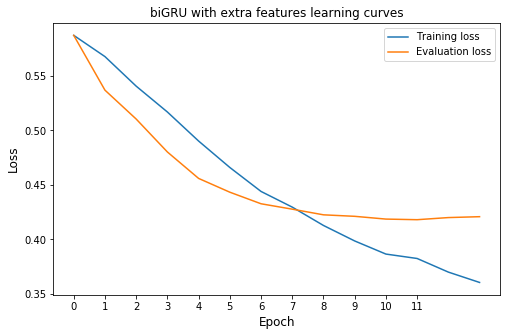

In [18]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('biGRU with extra features learning curves')
plt.xticks(ticks=range(12))
plt.legend()
plt.show()

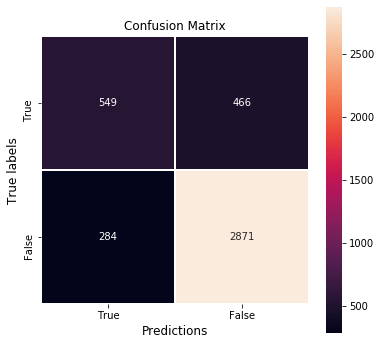

In [19]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [20]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/drugreview_feat_clean/test_feat_clean.csv',
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                     'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= 5
test_dataset = test_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                             'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [21]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
2,given sample doctor mg hours lower abdominal g...,-0.01117,0.4058,140.0,0.06430,0.02856,0.0,0.0,0.0,0.0,0.0,False
3,given medication post hysteroscopy suffered se...,0.12500,0.4937,68.0,0.02942,0.00000,0.0,0.0,0.0,0.0,0.0,True
4,loperamide helpful diarrhea fewer caplets help...,0.20000,0.3000,29.0,0.03450,0.03450,0.0,0.0,0.0,0.0,0.0,True
10,use claritin d seasonal allergies started taki...,0.20900,0.5366,120.0,0.08330,0.01666,0.0,0.0,0.0,0.0,0.0,True
15,worked immediate effects noticeable long term,-0.05000,0.4000,13.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,True


In [22]:
# Instantiate the StandardScaler
test_scaler = StandardScaler()
# Scale the features
test_dataset.iloc[:, 3:11] = test_scaler.fit_transform(test_dataset.iloc[:, 3:11])

In [23]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
3069/8377 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 54
Mapped words to indices
Batches created


In [24]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

In [25]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.807. Test error: 0.435


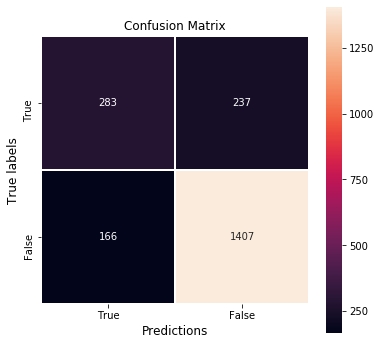

In [26]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

Thanks to using additional features our model achieved the generalization error of 0.807, which is 0.006 lower than in the model without using extracted features. Even a superior result is possible, but the precise process of hyperparameters fine-tuning will be required.